In [26]:


%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

from jaxkineticmodel.kinetic_mechanisms import JaxKineticMechanisms as jm
from jaxkineticmodel.building_models import JaxKineticModelBuild as jkm
from jaxkineticmodel.kinetic_mechanisms import JaxKineticMechanismsCustom as jcm


import jax.numpy as jnp
import equinox
import pandas as pd
import matplotlib.pyplot as plt
from jaxkineticmodel.load_sbml.export_sbml import SBMLExporter
from jaxkineticmodel.load_sbml.sbml_model import SBMLModel

v_glt= jkm.Reaction(
    name= "v_GLT",
    species=['ECglucose','ICglucose'],
    stoichiometry=[-1, 1],
    compartments= ['e','c'],
    mechanism=jm.Jax_Facilitated_Diffusion(substrate="ECglucose",product="ICglucose",
                                           vmax="p_GLT_VmGLT",km_internal="p_GLT_KmGLTGLCi",
                                           km_external="p_GLT_KmGLTGLCo",))

v_hxk= jkm.Reaction(
    name= "v_HXK",
    species=['ICATP','ICglucose',"ICADP",'ICT6P'],
    stoichiometry=[-1,-1 ,1, 1],
    compartments=['c','c','c','c'],
    mechanism=jcm.Jax_MM_Rev_BiBi_w_Inhibition(substrate1="ICATP",substrate2="ICglucose",
                                              product1="ICADP",product2="ICATP",modifier="ICT6P",
                                              vmax="p_HXK_Vmax",k_equilibrium="p_HXK1_Keq",km_substrate1="p_HXK1_Katp",
                                              km_substrate2="p_HXK1_Kglc",km_product1="p_HXK1_Kadp",
                                              km_product2="p_HXK1_Kg6p",ki_inhibitor="p_HXK1_Kt6p",))
v_nth1= jkm.Reaction(
    name="v_NTH1",
    species=['ICtreh','ICglucose'],
    stoichiometry=[-1,2],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="ICtreh",
                                  vmax="p_NTH1_Vmax",
                                  km_substrate="p_NTH1_Ktre"))

v_pgi= jkm.Reaction(
    name="v_PGI",
    species=['ICG6P','ICF6P'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Rev_UniUni(substrate="ICG6P",product="ICF6P",
                                   vmax="p_PGI1_Vmax",k_equilibrium="p_PGI1_Keq",
                                   km_substrate="p_PGI1_Kg6p",km_product="p_PGI1_Kf6p",))

v_sinkg6p= jkm.Reaction(
    name="v_sinkG6P",
    species=['ICG6P'],
    stoichiometry=[-1],
    compartments=['c'],
    mechanism=jm.Jax_MM_Sink(substrate="ICG6P",
                             v_sink="poly_sinkG6P",
                             km_sink="km_sinkG6P"))

v_sinkf6p= jkm.Reaction(name="v_sinkf6P",
                        species=['ICF6P'],
                        stoichiometry=[1],
                        compartments=['c'],
                        mechanism=jm.Jax_MM_Sink(substrate="ICF6P",
                                                 v_sink="poly_sinkF6P",
                                                 km_sink="km_sinkF6P"))

v_pgm1= jkm.Reaction(
    name="v_PGM1",
    species=['ICG1P','ICG6P'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism= jm.Jax_MM_Rev_UniUni(substrate="ICG1P",product="ICG6P",
                                 vmax="p_PGM1_Vmax",k_equilibrium="p_PGM1_Keq",
                                 km_substrate="p_PGM1_Kg1p",km_product="p_PGM1_Kg6p"))# to do v_TPS1 for 2nd rate law

## look into how to deal with arbitrary arguments in compute()
v_tps1 = jkm.Reaction(
    name="v_TPS1",
    species=['ICG6P','ICATP','ICT6P','ICADP','ICPHOS'],
    stoichiometry=[-1,-1, 1, 1, 1],
    compartments=['c','c','c','c','c'],
    mechanism=jcm.TPS1_Func_TEMP(substrate1="ICG6P",substrate2="ICG1P",
                                 vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",
                                 km_substrate2="p_TPS1_Kudp_glc",k_a='p_TPS1_KmF6P',
                                 activator="ICF6P")) #ICF6P is an activator, might be recognized as parameter
v_tps2= jkm.Reaction(
    name="v_TPS2",
    species=["ICT6P","ICtreh","ICPHOS"],
    stoichiometry=[-1,1,1],
    compartments=['c','c','c'],
    mechanism=jcm.Jax_MM_Irrev_Bi_w_Inhibition(substrate="ICT6P",
                                               product="ICPHOS",
                                               vmax="p_TPS2_Vmax",
                                               km_substrate1="p_TPS2_Kt6p",
                                               ki="p_TPS2_Kpi"))

v_pfk=jkm.Reaction(
    name="v_PFK",
    species=['ICF6P','ICATP','ICFBP','ICAMP'],
    stoichiometry=[-1,-1,1,1],
    compartments=['c','c','c','c'],
    mechanism=jcm.Jax_PFK(substrate1="ICF6P",substrate2="ICATP",product="ICFBP",
                      modifiers="ICAMP",vmax="p_PFK_Vmax",kr_F6P="p_PFK_Kf6p",
                      kr_ATP="p_PFK_Katp",gr="p_PFK_gR",c_ATP="p_PFK_Catp",
                      ci_ATP="p_PFK_Ciatp",ci_AMP="p_PFK_Camp",ci_F26BP="p_PFK_Cf26bp",
                      ci_F16BP="p_PFK_Cf16bp",l="p_PFK_L",kATP="p_PFK_Kiatp",kAMP="p_PFK_Kamp",
                      F26BP="p_PFK_F26BP",kF26BP="p_PFK_Kf26bp",kF16BP="p_PFK_Kf16bp"))
v_ald=jkm.Reaction(
    name="v_ALD",
    species=['ICFBP','ICGAP','ICDHAP'],
    stoichiometry=[-1,-1,1],
    compartments=['c','c','c'],
    mechanism=jm.Jax_MM_Rev_UniBi(substrate="ICFBP",product1="ICGAP",product2="ICDHAP",
                                   vmax="p_FBA1_Vmax",k_equilibrium="p_FBA1_Keq",
                                   km_substrate="p_FBA1_Kf16bp",km_product1="p_FBA1_Kglyceral3p",km_product2="p_FBA1_Kdhap",))

v_tpi1=jkm.Reaction(
    name="v_TPI1",
    species=['ICDHAP','ICGAP'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Rev_UniUni(substrate="ICDHAP",product="ICGAP",vmax="p_TPI1_Vmax",
                                   k_equilibrium="p_TPI1_Keq",km_substrate="p_TPI1_Kdhap",
                                   km_product="p_TPI1_Kglyceral3p",))

v_sinkgap=jkm.Reaction(
    name="v_sinkGAP",
    species=['ICGAP','ICPHOS'],
    stoichiometry=[1,-1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Sink(substrate="ICGAP",v_sink="poly_sinkGAP",
                             km_sink="poly_sinkGAP"))

## look into how to deal with arbitrary arguments in compute()
v_g3pdh=jkm.Reaction(
    name="v_3GPDH",
    species=['ICDHAP','ICNADH','ICG3P','ICNAD'],
    stoichiometry=[-1,-1,1,1],
    compartments=['c','c','c','c'],
    mechanism=jcm.G3PDH_Func_TEMP(substrate1="ICDHAP",
                                               substrate2="ICNADH",
                                               product1="ICG3P",
                                               product2="ICNAD",
                                               modifier1="ICFBP",
                                               modifier2="ICATP",
                                               modifier3="ICADP",
                                               vmax="p_GPD1_Vmax",
                                               k_equilibrium="p_GPD1_Keq",
                                               km_substrate1="p_GPD1_Kdhap",
                                               km_substrate2="p_GPD1_Knadh",
                                               km_product1="p_GPD1_Kglyc3p",
                                               km_product2="p_GPD1_Knad",
                                               ka1="p_GPD1_Kf16bp",
                                               ka2="p_GPD1_Katp",
                                               ka3="p_GPD1_Kadp",))

v_gapdh=jkm.Reaction(
    name="v_GAPDH",
    species=['ICGAP','ICNAD','ICPHOS','ICBPG','ICNADH'],
    stoichiometry=[-1,-1,-1,1,1],
    compartments=['c','c','c','c','c'],
    mechanism= jcm.Jax_MM_Ordered_Bi_Tri(substrate1="ICGAP",substrate2="ICNAD",
                                                  substrate3="ICPHOS",product1="ICBPG",
                                                  product2="ICNADH",
                                                  vmax="p_GAPDH_Vmax",k_equilibrium="p_TDH1_Keq",
                                                  km_substrate1="p_TDH1_Kglyceral3p",km_substrate2="p_TDH1_Knad",
                                                  ki="p_TDH1_Kpi",km_product1="p_TDH1_Kglycerate13bp",km_product2="p_TDH1_Knadh"))


v_pgk= jkm.Reaction(
    name="v_PGK",
    species=['ICBPG','ICADP','IC3PG','ICATP'],
    stoichiometry=[-1,-1,1,1],
    compartments=['c','c','c','c'],
    mechanism= jm.Jax_MM_Rev_BiBi(substrate1="ICBPG",
                                   substrate2="ICADP",
                                   product1="IC3PG",
                                   product2="ICATP",
                                   vmax="p_PGK_VmPGK",
                                   k_equilibrium="p_PGK_KeqPGK",
                                   km_substrate1="p_PGK_KmPGKBPG",
                                   km_substrate2="p_PGK_KmPGKADP",
                                   km_product1="p_PGK_KmPGKP3G",
                                   km_product2="p_PGK_KmPGKATP",))

v_sink3pga=jkm.Reaction(
    name="v_sink3PGA",
    species=['IC3PG','ICPHOS'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism= jm.Jax_MM_Sink(substrate="IC3PG", v_sink="poly_sinkP3G", km_sink="km_sinkP3G"))


## look into how to deal with arbitrary arguments in compute()
v_hor2=jkm.Reaction(name="v_HOR2",
                    species=['ICG3P','ICglyc','ICPHOS'],
                    stoichiometry=[-1, 1, 1],
                    compartments=['c','c','c'],
                    mechanism=jcm.HOR2_Func_TEMP(substrate="ICG3P",
                                                 vmax="p_HOR2_Vmax",
                                                 km_substrate="p_HOR2_Kglyc3p",
                                                 inhibitor="ICPHOS",
                                                 k_I="p_HOR2_Kpi"))

### next up  v_GlycT
v_glyct=jkm.Reaction(
    name="v_GlycT",
    species=['ICglyc','ECglyc'],
    stoichiometry=[-1,1],
    compartments=['c','e'],
    mechanism= jm.Jax_Diffusion(substrate="ICglyc",
                                 enzyme="f_GLYCEROL_e",
                                 transport_coef="p_GlycerolTransport"))

v_pgm=jkm.Reaction(
    name="v_PGM",
    species=['IC3PG','IC2PG'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Rev_UniUni(substrate="IC3PG",
                                   product="IC2PG",
                                   vmax="p_PGM_Vm",
                                   k_equilibrium="p_PGM_Keq",
                                   km_substrate="p_PGM_K3pg",
                                   km_product="p_PGM_K2pg",))

v_eno2=jkm.Reaction(
    name="v_ENO2",
    species=['IC2PG','ICPEP'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism= jm.Jax_MM_Rev_UniUni(substrate="IC2PG",
                                    product="ICPEP",
                                    vmax="p_ENO1_Vm",
                                    k_equilibrium="p_ENO1_Keq",
                                    km_substrate="p_ENO1_K2pg",
                                    km_product="p_ENO1_Kpep",))

v_sinkpep=jkm.Reaction(
    name="v_sinkPEP",
    species=['ICPEP'],
    stoichiometry=[-1],
    compartments=['c'],
    mechanism= jm.Jax_MM_Sink(substrate="ICPEP",
                              v_sink="poly_sinkPEP",
                              km_sink="km_sinkPEP") )

v_pyk1=jkm.Reaction(
    name='v_PYK1',
    species=['ICPEP','ICADP','ICPYR','ICATP'],
    stoichiometry=[-1,-1, 1, 1],
    compartments=['c','c','c', 'c'],
    mechanism=jcm.Jax_Hill_Irreversible_Bi_Activation(substrate1="ICPEP",
                                                      substrate2="ICADP",
                                                      activator="ICFBP",
                                                      product="ICATP",
                                                      vmax="p_PYK1_Vm",
                                                      hill="p_PYK1_hill",
                                                      k_substrate1="p_PYK1_Kpep",
                                                      k_substrate2="p_PYK1_Kadp",
                                                      k_product="p_PYK1_Katp",
                                                      k_activator="p_PYK1_Kf16bp",
                                                      l="p_PYK1_L",))
v_sinkpyr=jkm.Reaction(
    name='v_sinkPYR',
    species=['ICPYR'],
    stoichiometry=[-1],
    compartments=['c'],
    mechanism= jm.Jax_MM_Sink(substrate="ICPYR",
                              v_sink="poly_sinkPYR",
                              km_sink="km_sinkPYR"))

v_adh=jkm.Reaction(
    name='v_ADH',
    species=['ICNAD','ICETOH','ICNADH','ICACE'],
    stoichiometry=[1, 1, -1, -1],
    compartments=['c','c','c','c'],
    mechanism= jcm.Jax_ADH(NAD="ICNAD",
                           ETOH="ICETOH",
                           NADH="ICNADH",
                           ACE="ICACE",
                           vmax="p_ADH_VmADH",
                           k_equilibrium="p_ADH_KeqADH",
                           km_substrate1="p_ADH_KiADHNAD",
                           km_substrate2="p_ADH_KmADHETOH",
                           km_product1="p_ADH_KmADHACE",
                           km_product2="p_ADH_KmADHNADH",
                           ki_substrate1="p_ADH_KiADHNAD",
                           ki_substrate2="p_ADH_KiADHETOH",
                           ki_product1="p_ADH_KiADHACE",
                           ki_product2="p_ADH_KiADHNADH",
                           exprs_cor="p_ADH_ExprsCor",))

v_sinkace=jkm.Reaction(
    name='v_sinkACE',
    species=['ICACE'],
    stoichiometry=[-1],
    compartments=['c'],
    mechanism= jm.Jax_MM_Sink(substrate="ICACE",
                              v_sink="poly_sinkACE",
                              km_sink="km_sinkACE"))

v_etoht=jkm.Reaction(
    name="v_ETOHT",
    species=['ICETOH','ECETOH'],
    stoichiometry=[-1,1],
    compartments=['c','e'],
    mechanism=jm.Jax_Diffusion(substrate="ICETOH",
                               enzyme="f_ETOH_e",
                               transport_coef="p_kETOHtransport"))

v_atpmito=jkm.Reaction(
    name='v_ATPMITO',
    species=['ICATP','ICPHOS','ICADP'],
    stoichiometry=[1,-1,-1],
    compartments=['c','c','c'],
    mechanism=jm.Jax_MM_Irrev_Bi(substrate1="ICADP",
                                 substrate2="ICPHOS",
                                 vmax="p_mitoVmax",
                                 km_substrate1="p_mitoADPKm",
                                 km_substrate2="p_mitoPiKm"))

v_atpase=jkm.Reaction(
    name="v_ATPASE",
    species=['ICATP','ICPHOS','ICADP'],
    stoichiometry=[-1,1,1],
    compartments=['c','c','c'],
    mechanism= jcm.Jax_ATPase(substrate="ICATP",
                               product="ICADP",
                               ATPase_ratio="p_ATPase_ratio"))
v_adk=jkm.Reaction(
    name="v_ADK",
    species=['ICADP','ICATP','ICAMP'],
    stoichiometry=[-2,1,1],
    compartments=['c','c','c'],
    mechanism=jcm.Jax_MA_Rev_Bi(substrate1="ICADP",
                               substrate2="ICADP",
                               product1="ICATP",
                               product2="ICAMP",
                               k_equilibrium="p_ADK1_Keq",
                               k_fwd="p_ADK1_k"))
v_vacpi=jkm.Reaction(
    name="v_VACPI",
    species=['ICPHOS'],
    stoichiometry=[1],
    compartments=['c'],
    mechanism= jcm.Jax_MA_Rev(substrate="ICPHOS",
                              k="p_vacuolePi_k",
                              steady_state_substrate="p_vacuolePi_steadyStatePi")
)

v_amd1=jkm.Reaction(
    name="v_AMD1",
    species=['ICAMP','ICIMP'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jcm.Jax_Amd1(substrate="ICAMP",
                           product="ICATP",
                           modifier="ICPHOS",
                           vmax="p_Amd1_Vmax",
                           k50="p_Amd1_K50",
                           ki="p_Amd1_Kpi",
                           k_atp="p_Amd1_Katp",))
v_ade1312=jkm.Reaction(
    name="v_ADE1312",
    species=['ICIMP','ICAMP'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MA_Irrev(substrate="ICIMP",
                              k_fwd="p_Ade13_Ade12_k"))
v_isn1=jkm.Reaction(
    name="v_ISN1",
    species=['ICIMP','ICPHOS','ICINO'],
    stoichiometry=[-1,1,1],
    compartments=['c','c','c'],
    mechanism=jm.Jax_MA_Irrev(substrate="ICIMP",
                              k_fwd="p_Isn1_k"))


v_pnp1=jkm.Reaction(
    name="v_PNP1",
    species=['ICINO','ICPHOS','ICHYP'],
    stoichiometry=[-1,-1,1],
    compartments=['c','c','c'],
    mechanism=jm.Jax_MA_Irrev(substrate="ICINO",
                              k_fwd="p_Pnp1_k"))

v_hpt1=jkm.Reaction(
    name="v_HPT1",
    species=['ICIMP','ICHYP'],
    stoichiometry=[1,-1],
    compartments=['c','c'],
    mechanism=jm.Jax_MA_Irrev(substrate="ICHYP", k_fwd="p_Hpt1_k"))


/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### Test if input is the same as output sbml

In [27]:
compartments={'c':1,'e':1}
reactions=[v_hxk,v_glt,v_nth1,v_pgi,
           v_sinkg6p,v_sinkf6p,v_pgm1,
           v_tps1,v_tps2,v_pfk,v_ald,
           v_tpi1,v_sinkgap,v_g3pdh,
           v_gapdh,v_pgk,v_sink3pga,
           v_hor2,v_glyct, v_pgm,
           v_eno2,v_sinkpep,v_pyk1,
           v_sinkpyr,v_adh,v_sinkace,
           v_etoht,v_atpmito,v_atpase,
           v_adk,v_vacpi,v_amd1,
           v_ade1312,v_isn1,v_pnp1,v_hpt1
           ]

kmodel = jkm.JaxKineticModel_Build(reactions, compartments)
kmodel_sim = jkm.NeuralODEBuild(kmodel)


S=kmodel.stoichiometric_matrix

y0=jnp.ones(len(kmodel.stoichiometric_matrix.index))

params=dict(zip(kmodel.parameter_names,jnp.ones(len(kmodel.parameter_names))))


ts=jnp.linspace(0,4,1000)
# kmodel_sim = equinox.filter_jit(kmodel_sim)
ys = kmodel_sim(ts, y0, params)
ys = pd.DataFrame(ys, columns=kmodel.species_names)




12:02:54,930 - jaxkineticmodel.building_models.JaxKineticModelBuild - INFO - parameter p_HXK1_Katp is in multiple reactions.
12:02:54,930 - jaxkineticmodel.building_models.JaxKineticModelBuild - INFO - parameter p_HXK1_Katp is in multiple reactions.


In [28]:
kmodel.stoichiometric_matrix.index

Index(['ICATP', 'ICglucose', 'ICADP', 'ICT6P', 'ECglucose', 'ICtreh', 'ICG6P',
       'ICF6P', 'ICG1P', 'ICPHOS', 'ICFBP', 'ICAMP', 'ICGAP', 'ICDHAP',
       'ICNADH', 'ICG3P', 'ICNAD', 'ICBPG', 'IC3PG', 'ICglyc', 'ECglyc',
       'IC2PG', 'ICPEP', 'ICPYR', 'ICETOH', 'ICACE', 'ECETOH', 'ICIMP',
       'ICINO', 'ICHYP'],
      dtype='object')

In [29]:
print(len(y0)) #there should be 29
print(len(params)) #there should 141
print(len(reactions)) # there should be 38

30
134
36


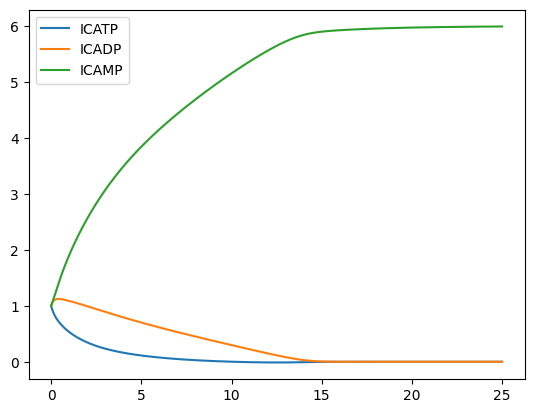

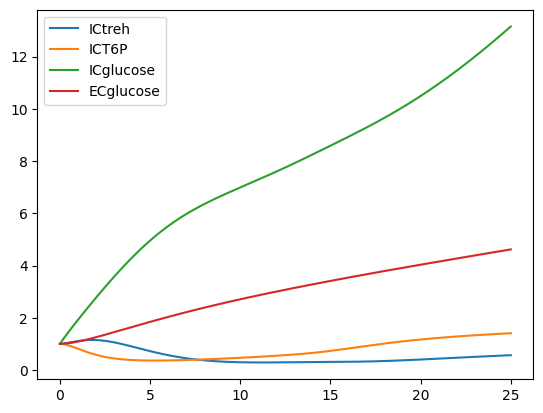

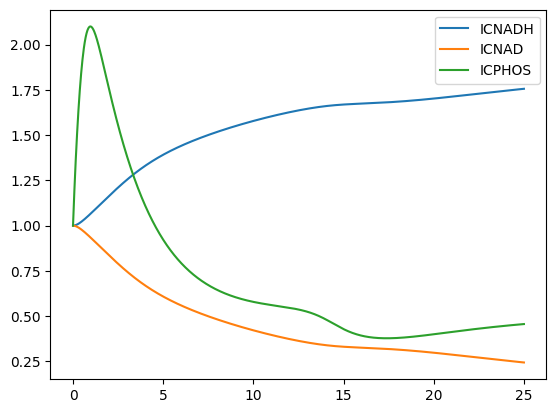

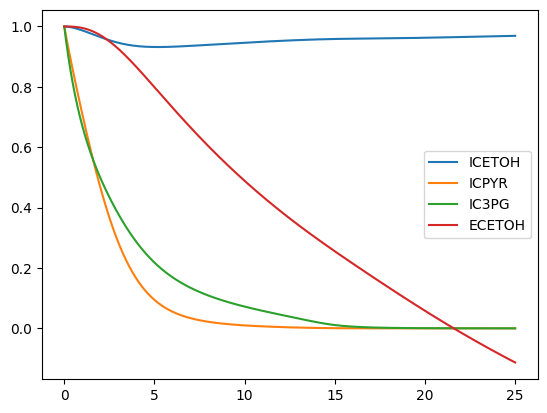

In [18]:
ts=jnp.linspace(0,25,1000)
# y0=y0.at[0].set(1.)

ys = kmodel_sim(ts, y0, params)
ys = pd.DataFrame(ys, columns=kmodel.species_names)


names=['ICATP','ICADP','ICAMP']
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()
plt.show()

names=['ICtreh','ICT6P','ICglucose','ECglucose']
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()
plt.show()

names=['ICNADH','ICNAD',"ICPHOS"]
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()
plt.show()

names=['ICETOH','ICPYR',"IC3PG",'ECETOH']
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()


In [6]:
ys = kmodel_sim(ts, y0, params)
ys = pd.DataFrame(ys, columns=kmodel.species_names)


output_dir="models/manual_implementations/export_sbml_test/"
model_name="glycolysis_draf1"

sbml = SBMLExporter(model=kmodel_sim)

sbml.export(initial_conditions=y0,
            parameters=params,
            output_file=f"{output_dir}/{model_name}.xml")

11:35:27,773 - jaxkineticmodel.load_sbml.export_sbml - INFO - Exporting Neural ODE model of instance <class 'jaxkineticmodel.building_models.JaxKineticModelBuild.NeuralODEBuild'>
1


In [9]:
kmodel=SBMLModel(f"{output_dir}/{model_name}.xml")



S=kmodel._get_stoichiometric_matrix()

JaxKmodel = kmodel.get_kinetic_model()

ts = jnp.linspace(0,20,1000)




11:36:11,312 - jaxkineticmodel.load_sbml.sbml_model - INFO - No internal inconsistencies found
11:36:11,313 - jaxkineticmodel.load_sbml.sbml_model - INFO - Model loaded.
11:36:11,313 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of species: 28
11:36:11,313 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of reactions: 31
11:36:11,314 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of global parameters: 126
11:36:11,314 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
11:36:11,314 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of lambda function definitions: 0
11:36:11,315 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of assignment rules: 0
11:36:11,315 - jaxkineticmodel.load_sbml.sbml_model - INFO -  number of event rules: 0
11:36:11,499 - jaxkineticmodel.load_sbml.jax_kinetic_model - INFO - Compile complete


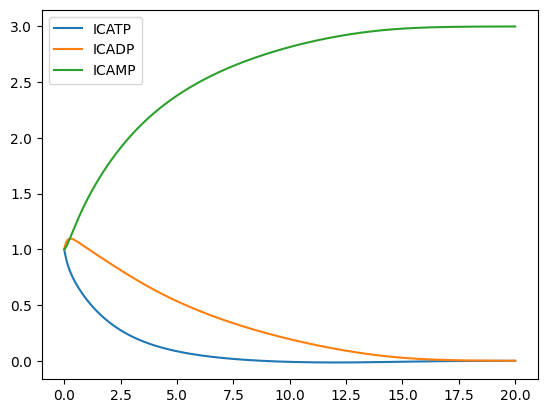

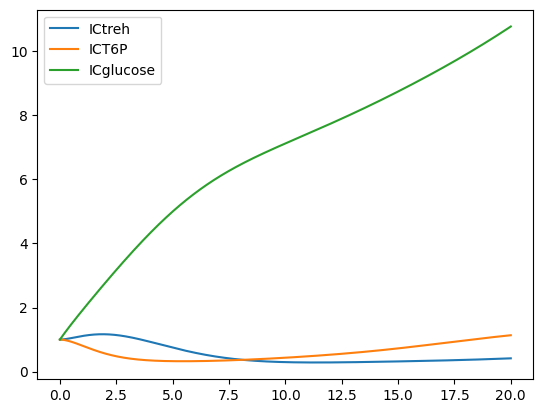

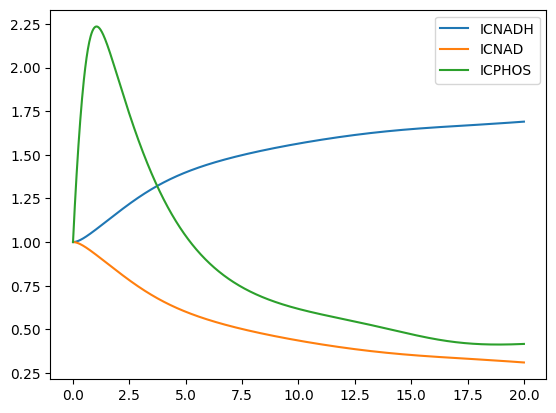

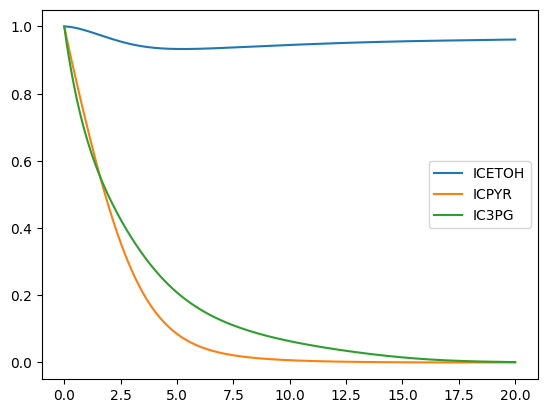

In [10]:
ys = kmodel_sim(ts, y0, params)
ys = pd.DataFrame(ys, columns=kmodel.species_names)

names=['ICATP','ICADP','ICAMP']
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()
plt.show()

names=['ICtreh','ICT6P','ICglucose']
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()
plt.show()

names=['ICNADH','ICNAD',"ICPHOS"]
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()
plt.show()

names=['ICETOH','ICPYR',"IC3PG"]
for name in names:
    plt.plot(ts,ys[name],label=name)
plt.legend()